# CycleGAN: toy example
This is an toy example that demonstrates CycleGAN and our assumption of semantic correspondence in the color dataset.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import itertools

import matplotlib.pyplot as plt

### Functions for generation and visualization of the image batches

In [0]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    grid = make_grid(batch, nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [0]:
def random_image_data(size=(2**21, 3, 1, 1), ratio=0.5, offset=0.2, color=0):
    '''Generates a random image batch 
    consisting of two modes (dark and light images)
    
    Parameters:
    size (tuple): The dimensions of the image batch (batch_size, channels, width, length)
    ratio (float): The ratio of light to dark images
    offset (float): The brightness of the images relative to black and bright
    color (int): Red = 0, green = 1, blue = 2
    
    Returns:
    image_batch (Tensor): The generated image batch
    
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio
    image_batch = torch.zeros(size)
    image_batch[:, color] += offset # light color
    image_batch[idx, color] = 1 - offset # dark color 
    return image_batch

### The dataset class

In [0]:
class ColorDataset(Dataset):
    '''The dataloader for the color images
    '''
    def __init__(self, ratio=0.5, offset=0.2, color=0):
        '''  
        Parameters:
        ratio (float): The ratio of light to dark images
        offset (float): The brightness of the images relative to black and bright
        color (int): Red = 0, green = 1, blue = 2
        '''
        self.offset = offset
        self.ratio = ratio
        self.color = color
        
        self.dataset = random_image_data(ratio=self.ratio, 
                                         offset=self.offset, 
                                         color=self.color)
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each mode in the domain
        
        '''
        example_imgs = torch.zeros(size=(2, 3, 1, 1))

        example_imgs[0, self.color] += self.offset # light color
        example_imgs[1, self.color] = 1 - self.offset # dark color
        return example_imgs   

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

### The networks

In [0]:
class Discriminator(nn.Module):
    '''A simple joint discriminator network'''

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out

In [0]:
class Generator(nn.Module):
    '''A simple conditional generator network'''

    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out.unsqueeze(-1).unsqueeze(-1)

### A demonstration of the two domains
The idea here is that we create two domains: A red and a green domain. The domains consist of two modes: dark and light images. The big assumption here for our purpose is that the dark and light images have semantic correspondance, so for example: dark red will be translated to dark green.

We can adjust the intensity of the images (offset) and the ratio of the modes for the experiment. In the visualiztion you can see the elements of the dataset. In the histogram you can see the modes.

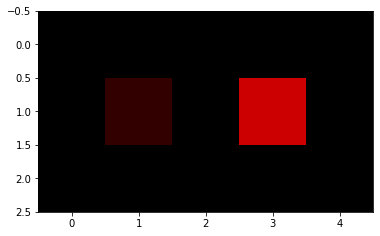

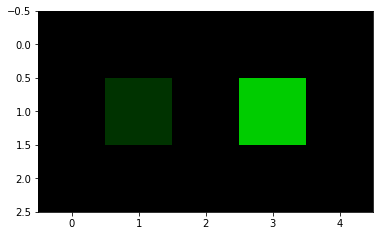

In [7]:
# Settings for domain A (red)
offset_A = 0.2
ratio_A = 0.5
color_A = 0
dataset_A = ColorDataset(offset=offset_A, ratio=ratio_A, color=color_A)
dataloader_A = DataLoader(dataset_A, batch_size=256, shuffle=True)

# Settings for domain B (green)
offset_B = 0.2
ratio_B = 0.5
color_B = 1
dataset_B = ColorDataset(offset=offset_B, ratio=ratio_B, color=color_B)
dataloader_B = DataLoader(dataset_B, batch_size=256, shuffle=True)

visualize_img_batch(dataset_A.example_imgs)
visualize_img_batch(dataset_B.example_imgs)

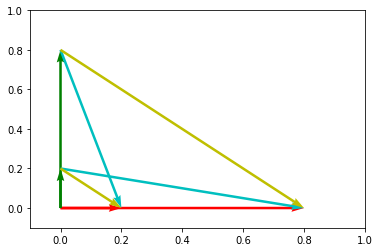

Total distance of cyan   (light to dark, dark to light) 1.6492422819137573
Total distance of yellow (light to light, dark to dark) 1.4142136573791504


In [8]:
R = dataset_A.example_imgs[:, :2].squeeze()
G = dataset_B.example_imgs[:, :2].squeeze()
sem1 = torch.stack((R[1], R[0]))-G
sem2 = R-G

plt.quiver([0, 0], [0, 0], R[:, 0], R[:, 1], angles='xy', scale_units='xy', color=['r', 'r'], scale=1)
plt.quiver([0, 0], [0, 0], G[:, 0], G[:, 1], angles='xy', scale_units='xy', color=['g', 'g'], scale=1)
plt.quiver(G[:, 0], G[:, 1], sem1[:, 0], sem1[:, 1], angles='xy', scale_units='xy', color=['c', 'c'], scale=1)
plt.quiver(G[:, 0], G[:, 1], sem2[:, 0], sem2[:, 1], angles='xy', scale_units='xy', color=['y', 'y'], scale=1)

plt.xlim(-0.1, 1)
plt.ylim(-0.1, 1)
plt.show()

print('Total distance of cyan   (light to dark, dark to light)', ((sem1[:, 0]**2 + sem1[:, 1]**2)**0.5).sum().item())
print('Total distance of yellow (light to light, dark to dark)', ((sem2[:, 0]**2 + sem2[:, 1]**2)**0.5).sum().item())

True ratio domain A: 0.5
Count: tensor([137, 119]) Ratio in this batch: tensor([0.5352, 0.4648])


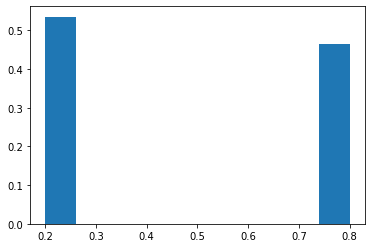

True ratio domain B: 0.5
Count: tensor([130, 126]) Ratio in this batch: tensor([0.5078, 0.4922])


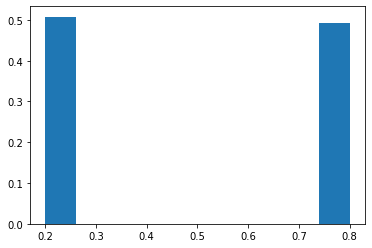

In [9]:
def plot_hist(data):
    data = data.view(3, -1).sum(0)
    plt.hist(data, weights=torch.ones(len(data))/len(data))
    x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    
    print('Count:', x_unique_count, 'Ratio in this batch:', x_unique_count/float(x_unique_count.sum()))

    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
    print('True ratio domain A:', dataloader_A.dataset.ratio)
    plot_hist(data_A)
    print('True ratio domain B:', dataloader_B.dataset.ratio)
    plot_hist(data_B)
    break

## The training loop

In [10]:
# Initialize the networks
generator_A = Generator()
generator_B = Generator()
discriminator_A = Discriminator()
discriminator_B = Discriminator()

# Initialize the optimizers
optimizer_g = optim.Adam(itertools.chain(generator_A.parameters(),
                                         generator_B.parameters()), lr=0.002, betas=(0.5, 0.999)) # lr=0.01)
optimizer_d = optim.Adam(itertools.chain(discriminator_A.parameters(),
                                         discriminator_B.parameters()), lr=0.002, betas=(0.5, 0.999))

# Store values
samples_A = []
samples_B = []

losses_g = []
losses_d = []

criterion_D = nn.MSELoss()
criterion_G = nn.MSELoss()
criterion_cycle = nn.MSELoss()
criterion_L2 = nn.MSELoss()

for epoch in range(1):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
        # Set gradients to zero
        optimizer_d.zero_grad()
        optimizer_g.zero_grad()

        # Forward
        fake_A = generator_A(real_B)
        fake_B = generator_B(real_A)
        
        rec_A = generator_A(fake_B)
        rec_B = generator_B(fake_A)
        
        pred_real_A = discriminator_A(real_A)
        pred_real_B = discriminator_B(real_B)
        
        pred_fake_A = discriminator_A(fake_A.detach())
        pred_fake_B = discriminator_B(fake_B.detach())
        
        # The loss function --------------------------------------------------------------------------------
        loss_D_real_A = criterion_D(pred_real_A, torch.ones((pred_real_A.shape)))
        loss_D_real_B = criterion_D(pred_real_B, torch.ones((pred_real_B.shape)))

        loss_D_fake_A = criterion_D(pred_fake_A, torch.zeros((pred_fake_A.shape)))
        loss_D_fake_B = criterion_D(pred_fake_B, torch.zeros((pred_fake_B.shape)))
        
        loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
        loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
        
        loss_G_A = criterion_G(discriminator_A(fake_A), torch.ones((pred_fake_A.shape)))
        loss_G_B = criterion_G(discriminator_B(fake_B), torch.ones((pred_fake_A.shape)))
        
        cycle_A = criterion_cycle(real_A, rec_A)
        cycle_B = criterion_cycle(real_B, rec_B)
        cycle = cycle_A + cycle_B
        
        loss_d = (loss_D_A + loss_D_B)
        loss_g = (loss_G_A + loss_G_B) + cycle
        # ---------------------------------------------------------------------------------------------------

        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        # Store values --------------------------------------------------------------------------------------
        losses_g += [loss_g.item()]
        losses_d += [loss_d.item()]
        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            samples_A += [fake_A.detach()]
            samples_B += [fake_B.detach()]
            print('step', i, 'loss_g', loss_g.item(), 'loss_d', loss_d.item())

step 0 loss_g 1.2163071632385254 loss_d 0.545628547668457
step 500 loss_g 0.582534670829773 loss_d 0.47999322414398193
step 1000 loss_g 0.5537616014480591 loss_d 0.49616140127182007
step 1500 loss_g 0.5060210227966309 loss_d 0.498257040977478
step 2000 loss_g 0.5062006115913391 loss_d 0.4968374967575073
step 2500 loss_g 0.504628598690033 loss_d 0.4954349398612976
step 3000 loss_g 0.4963374435901642 loss_d 0.4998437166213989
step 3500 loss_g 0.5005434155464172 loss_d 0.5000503063201904
step 4000 loss_g 0.5023040771484375 loss_d 0.4990973174571991
step 4500 loss_g 0.49856632947921753 loss_d 0.5002176761627197
step 5000 loss_g 0.5005705952644348 loss_d 0.5004980564117432
step 5500 loss_g 0.4991398751735687 loss_d 0.5004042387008667
step 6000 loss_g 0.5002163648605347 loss_d 0.5002371072769165
step 6500 loss_g 0.500056803226471 loss_d 0.500011146068573
step 7000 loss_g 0.500528872013092 loss_d 0.4998353123664856
step 7500 loss_g 0.49997788667678833 loss_d 0.4999917149543762
step 8000 loss_

In [11]:
'''def set_requires_grad(nets, requires_grad=False):
        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

# Initialize the networks
generator_A = Generator()
generator_B = Generator()
discriminator_A = Discriminator()
discriminator_B = Discriminator()

# Initialize the optimizers
optimizer_g = optim.Adam(itertools.chain(generator_A.parameters(),
                                         generator_B.parameters()), lr=0.002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(itertools.chain(discriminator_A.parameters(),
                                         discriminator_B.parameters()), lr=0.002, betas=(0.5, 0.999))

# Store values
samples_A = []
samples_B = []

losses_g = []
losses_d = []

criterion_D = nn.MSELoss()
criterion_G = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_L2 = nn.MSELoss()
criterionIdt = nn.L1Loss()

for epoch in range(1):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
        # Set gradients to zero
        optimizer_d.zero_grad()
        optimizer_g.zero_grad()

        # Forward
        fake_A = generator_A(real_B)
        fake_B = generator_B(real_A)
        
        rec_A = generator_A(fake_B)
        rec_B = generator_B(fake_A)
        
        pred_real_A = discriminator_A(real_A)
        pred_real_B = discriminator_B(real_B)
        
        pred_fake_A = discriminator_A(fake_A.detach())
        pred_fake_B = discriminator_B(fake_B.detach())
        
        # The loss function --------------------------------------------------------------------------------
        loss_D_real_A = criterion_D(pred_real_A, torch.ones((pred_real_A.shape)))
        loss_D_real_B = criterion_D(pred_real_B, torch.ones((pred_real_B.shape)))

        loss_D_fake_A = criterion_D(pred_fake_A, torch.zeros((pred_fake_A.shape)))
        loss_D_fake_B = criterion_D(pred_fake_B, torch.zeros((pred_fake_B.shape)))
        
        loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
        loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
        
        loss_G_A = criterion_G(discriminator_A(fake_A), torch.ones((pred_fake_A.shape)))
        loss_G_B = criterion_G(discriminator_B(fake_B), torch.ones((pred_fake_A.shape)))
        
        lambda_A = 10.0
        lambda_B = 10.0
        lambda_idt = 0.5

        cycle_A = criterion_cycle(real_A, rec_A) * lambda_A
        cycle_B = criterion_cycle(real_B, rec_B) * lambda_B
        cycle = cycle_A + cycle_B

        idt_A = generator_A(real_B)
        idt_B = generator_B(real_A)
        idt_A = criterionIdt(idt_A, real_B) * lambda_B * lambda_idt
        idt_B = criterionIdt(idt_B, real_A) * lambda_A * lambda_idt
        idt = idt_A + idt_B
        
        loss_d = (loss_D_A + loss_D_B)
        loss_g = (loss_G_A + loss_G_B) + cycle + idt
        # ---------------------------------------------------------------------------------------------------

        set_requires_grad([discriminator_A, discriminator_B], False)  # Ds require no gradients when optimizing Gs
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        set_requires_grad([discriminator_A, discriminator_B], True)  # Ds require no gradients when optimizing Gs
        optimizer_d.zero_grad()
        # Backward
        
        loss_d.backward()

        # Optimization step
        
        optimizer_d.step()

        # Store values --------------------------------------------------------------------------------------
        losses_g += [loss_g.item()]
        losses_d += [loss_d.item()]
        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            samples_A += [fake_A.detach()]
            samples_B += [fake_B.detach()]
            print('step', i, 'loss_g', loss_g.item(), 'loss_d', loss_d.item())'''

'def set_requires_grad(nets, requires_grad=False):\n        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations\n        Parameters:\n            nets (network list)   -- a list of networks\n            requires_grad (bool)  -- whether the networks require gradients or not\n        """\n        if not isinstance(nets, list):\n            nets = [nets]\n        for net in nets:\n            if net is not None:\n                for param in net.parameters():\n                    param.requires_grad = requires_grad\n\n# Initialize the networks\ngenerator_A = Generator()\ngenerator_B = Generator()\ndiscriminator_A = Discriminator()\ndiscriminator_B = Discriminator()\n\n# Initialize the optimizers\noptimizer_g = optim.Adam(itertools.chain(generator_A.parameters(),\n                                         generator_B.parameters()), lr=0.002, betas=(0.5, 0.999))\noptimizer_d = optim.Adam(itertools.chain(discriminator_A.parameters(),\n                             

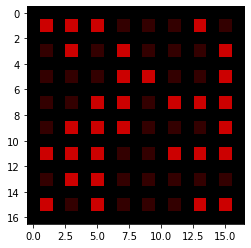

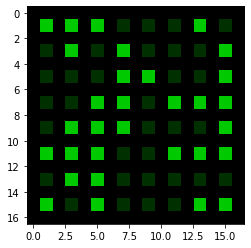

Count: tensor([29, 34, 34, 31, 37, 28, 28, 35]) Ratio in this batch: tensor([0.1133, 0.1328, 0.1328, 0.1211, 0.1445, 0.1094, 0.1094, 0.1367])


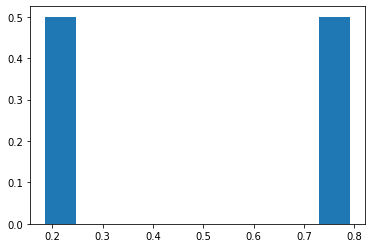

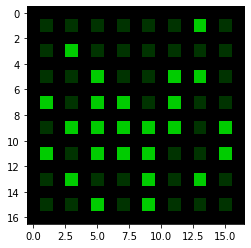

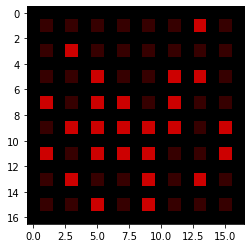

Count: tensor([35, 33, 27,  8, 16,  8, 24, 37, 35, 33]) Ratio in this batch: tensor([0.1367, 0.1289, 0.1055, 0.0312, 0.0625, 0.0312, 0.0938, 0.1445, 0.1367,
        0.1289])


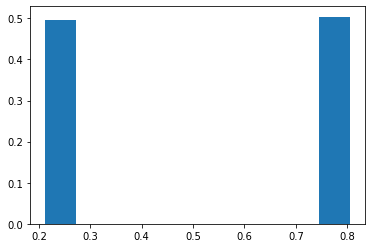

In [12]:
# Some generated images
visualize_img_batch(real_A.detach()[:64])
visualize_img_batch(fake_B.detach()[:64])
plot_hist(fake_B.detach())

visualize_img_batch(real_B.detach()[:64])
visualize_img_batch(fake_A.detach()[:64])
plot_hist(fake_A.detach())

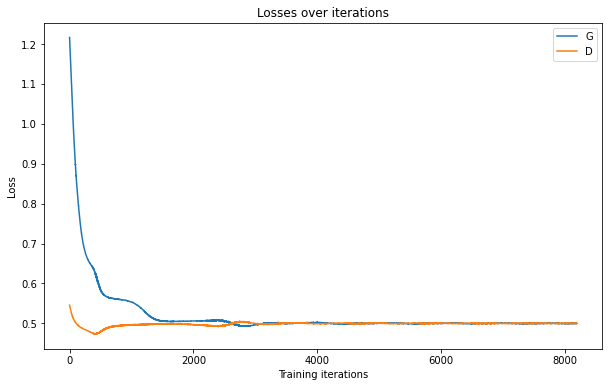

In [13]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(losses_g)
plt.plot(losses_d)
plt.legend(['G', 'D'])
plt.show()

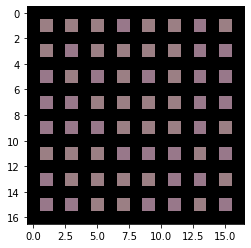

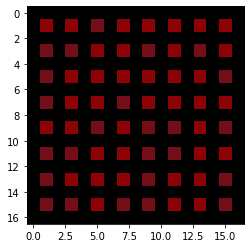

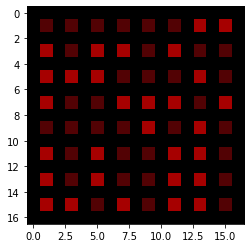

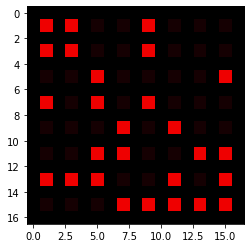

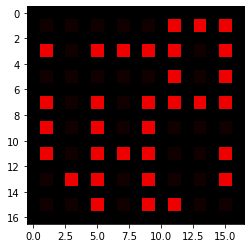

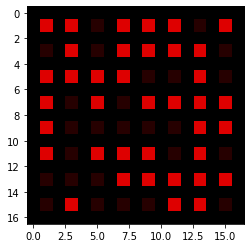

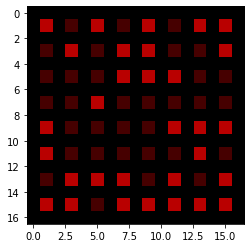

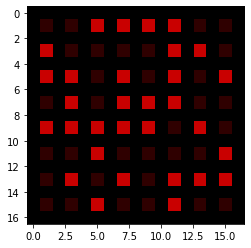

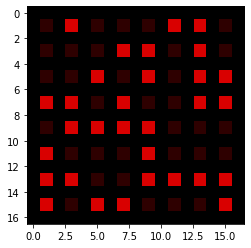

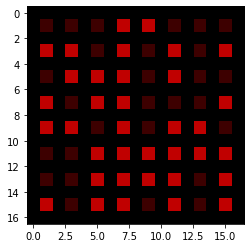

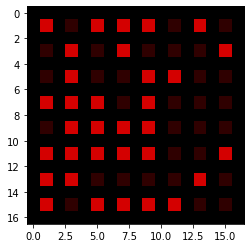

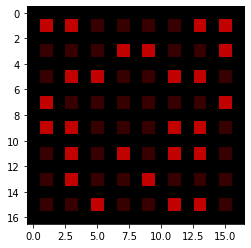

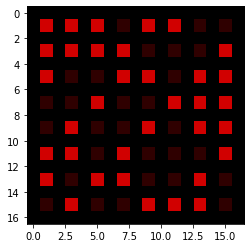

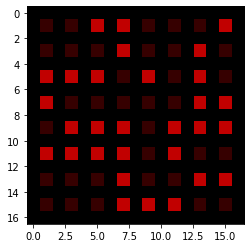

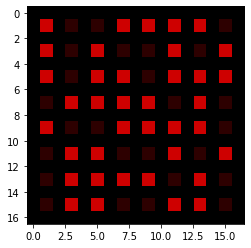

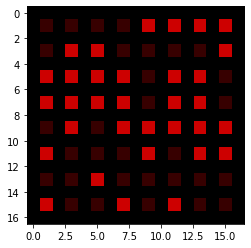

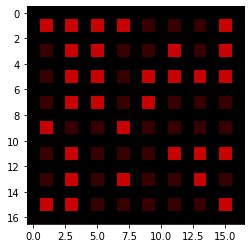

In [14]:
for img in samples_A:
    visualize_img_batch(img[:64])